In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

2025-01-11 17:04:51.238905: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-11 17:04:51.316625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736595291.351000    7889 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736595291.361260    7889 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 17:04:51.444882: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet.git

Cloning into 'Brain-Tumor-Classification-DataSet'...
remote: Enumerating objects: 3039, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3035 (from 1)
Receiving objects: 100% (3039/3039), 79.25 MiB | 2.36 MiB/s, done.


In [ ]:
data_dir = "/home/pes1ug22am100/Documents/Research and Experimentation/neuralNeurosis/Brain-Tumor-Classification-DataSet"
img_size = (224, 224)
batch_size = 32

### Data prep

In [ ]:
def prepare_data(train_dir, test_dir, img_size, batch_size):
    train_datagen = ImageDataGenerator(rescale=1.0/255)
    test_datagen = ImageDataGenerator(rescale=1.0/255)

    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True
    )

    test_gen = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False
    )

    return train_gen, test_gen

In [ ]:
train_dir = os.path.join(data_dir, "Training")
test_dir = os.path.join(data_dir, "Testing")
train_gen, test_gen = prepare_data(train_dir, test_dir, img_size, batch_size)
num_classes = len(train_gen.class_indices)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [ ]:
train_gen

In [ ]:
print(f"Number of classes: {len(train_gen.class_indices)}")
print(f"Class labels: {train_gen.class_indices}")

Number of classes: 4
Class labels: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


# Data Encoding

In [ ]:
def visualize_encoding(image_path, encoding_type='rate', time_window=100, max_spikes=20):
    # Select encoding function based on encoding_type
    if encoding_type == 'rate':
        encode_function = encode_rate_coding
    elif encoding_type == 'temporal':
        encode_function = encode_temporal_coding
    else:
        raise ValueError(f"Unsupported encoding type: {encoding_type}")

    # Get the spike train using the selected encoding method
    spike_train = encode_function(image_path, time_window, max_spikes)

    # Load the original image
    img = image.load_img(image_path, target_size=(128, 128), color_mode='grayscale')
    img_array = np.array(img) / 255.0

    # Create a figure to display the original and encoded images
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(img_array, cmap='gray')
    plt.title('Original MRI Image')

    # Encoded Image based on the encoding type
    plt.subplot(1, 2, 2)
    if encoding_type == 'rate':
        # For rate encoding, sum the spikes over time
        plt.imshow(np.sum(spike_train, axis=2), cmap='hot', interpolation='nearest')
        plt.title('Rate Coding Encoded Image')
    elif encoding_type == 'temporal':
        # For temporal encoding, display the first spike time
        plt.imshow(np.argmax(spike_train, axis=2), cmap='hot', interpolation='nearest')
        plt.title('Temporal Coding Encoded Image')

    plt.colorbar()
    plt.show()

In [ ]:
def random_class_sample(train_gen, encoding_type='rate', num_samples=1, time_window=100, max_spikes=20):
    class_names = list(train_gen.class_indices.keys())

    for class_name in class_names:
        class_dir = os.path.join(train_dir, class_name)
        images = os.listdir(class_dir)

        # Randomly select a sample from each class
        random_image = random.choice(images)
        image_path = os.path.join(class_dir, random_image)

        print(f"Displaying sample from class: {class_name}")

        # Visualize original image and encoded spike train
        visualize_encoding(image_path, encoding_type, time_window, max_spikes)

### Rate encoding

* Concept: In rate coding, the information is encoded in the firing rate of the neurons. The more intense the input, the higher the rate of spikes within a fixed time window.

* Implementation: Convert the pixel values of the MRI images into spike trains by using the pixel intensity to determine the spike rate over a specific time window. The greater the pixel value, the more spikes are generated.

In [ ]:
def encode_rate_coding(image_path, time_window=100, max_spikes=20):
    # Load image
    img = image.load_img(image_path, target_size=(128, 128), color_mode='grayscale')
    img_array = np.array(img) / 255.0  # Normalize the image

    # Initialize spike train
    spike_train = np.zeros((img_array.shape[0], img_array.shape[1], time_window))

    # Map pixel intensities to spike rates (higher intensity = more spikes)
    for i in range(img_array.shape[0]):
        for j in range(img_array.shape[1]):
            num_spikes = int(img_array[i, j] * max_spikes)  # Number of spikes is proportional to intensity
            spike_train[i, j, :num_spikes] = 1  # Set the spike train for the pixel

    return spike_train

Displaying sample from class: glioma_tumor


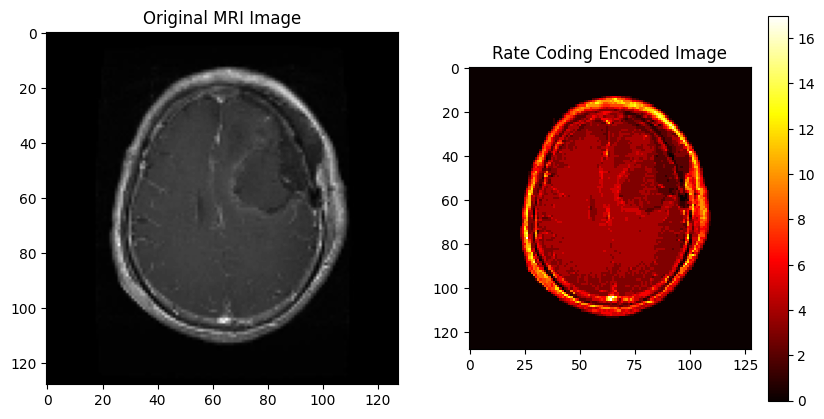

Displaying sample from class: meningioma_tumor


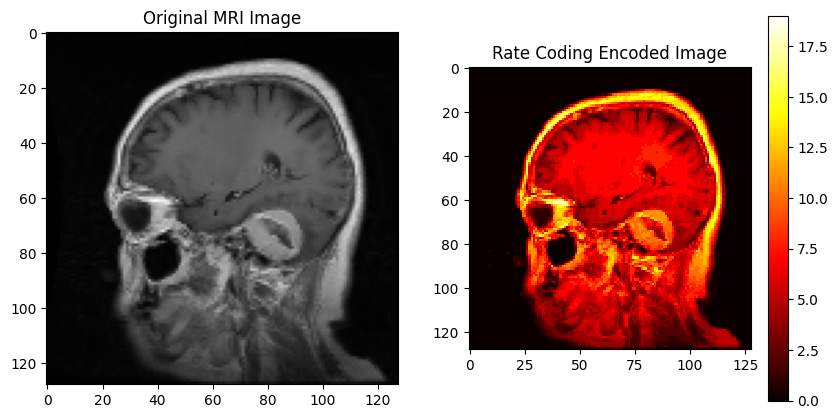

Displaying sample from class: no_tumor


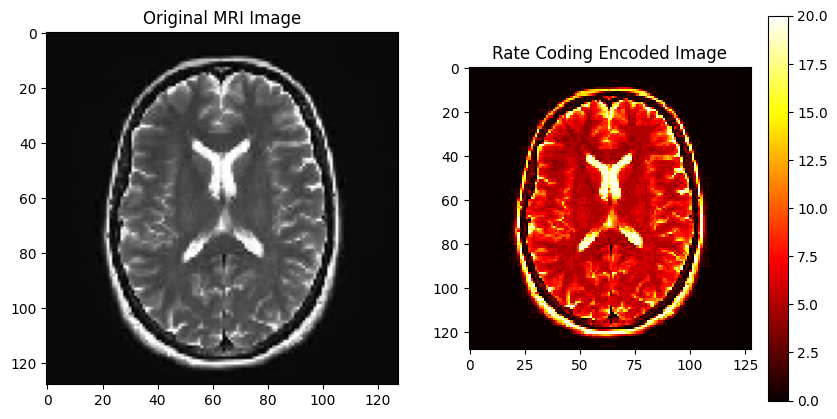

Displaying sample from class: pituitary_tumor


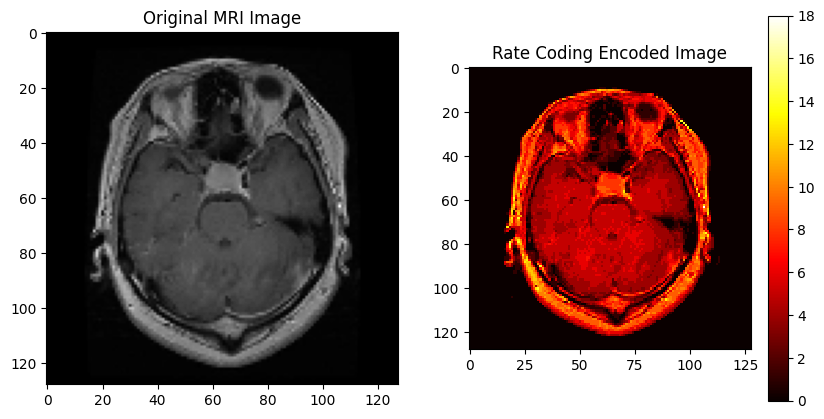

In [ ]:
random_class_sample(train_gen, encoding_type='rate', num_samples=1)

In [ ]:
# for potential reshaping to 4d inout
'''batch_size = all_spike_trains_array.shape[0]
height = all_spike_trains_array.shape[1]
width = all_spike_trains_array.shape[2]
time_steps = all_spike_trains_array.shape[3]

reshaped_data = all_spike_trains_array.reshape(batch_size, height, width, time_steps)'''

'batch_size = all_spike_trains_array.shape[0]\nheight = all_spike_trains_array.shape[1]\nwidth = all_spike_trains_array.shape[2]\ntime_steps = all_spike_trains_array.shape[3]\n\nreshaped_data = all_spike_trains_array.reshape(batch_size, height, width, time_steps)'

In [ ]:
# https://www.mdpi.com/2076-3425/12/7/863

### Temporal Coding

* Concept: Temporal coding uses the precise timing of spikes to encode information. For example, an image might be represented by the timing of the first spike in response to each pixel or group of pixels.

* How to implement: Map pixel values to the timing of the first spike. The first spike for higher intensity pixels occurs sooner than for lower intensity pixels.

In [ ]:
def encode_temporal_coding(image_path, time_window=100, max_spikes=20):
    # Load image
    img = image.load_img(image_path, target_size=(128, 128), color_mode='grayscale')
    img_array = np.array(img) / 255.0  # Normalize the image

    # Initialize spike train
    spike_train = np.zeros((img_array.shape[0], img_array.shape[1], time_window))

    # Map pixel intensities to spike times (higher intensity = earlier spike)
    for i in range(img_array.shape[0]):
        for j in range(img_array.shape[1]):
            num_spikes = int(img_array[i, j] * max_spikes)  # Number of spikes is proportional to intensity

            if num_spikes > 0:
                # Randomly distribute the spike times across the time window
                spike_times = np.random.choice(time_window, num_spikes, replace=False)
                spike_train[i, j, spike_times] = 1  # Set spikes at the randomly chosen time points

    return spike_train

Displaying sample from class: glioma_tumor


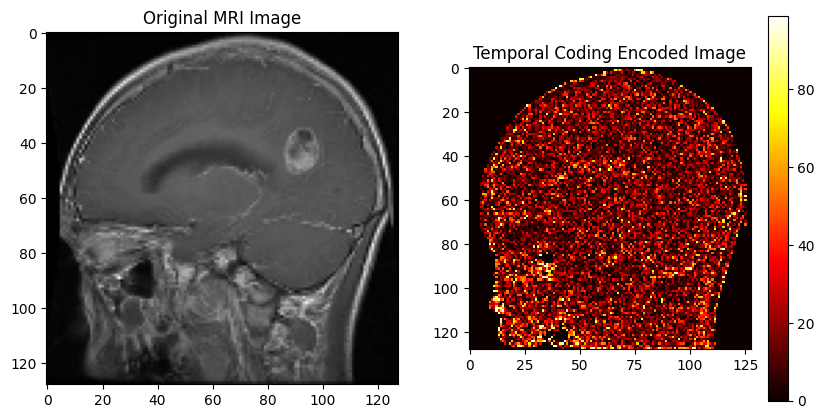

Displaying sample from class: meningioma_tumor


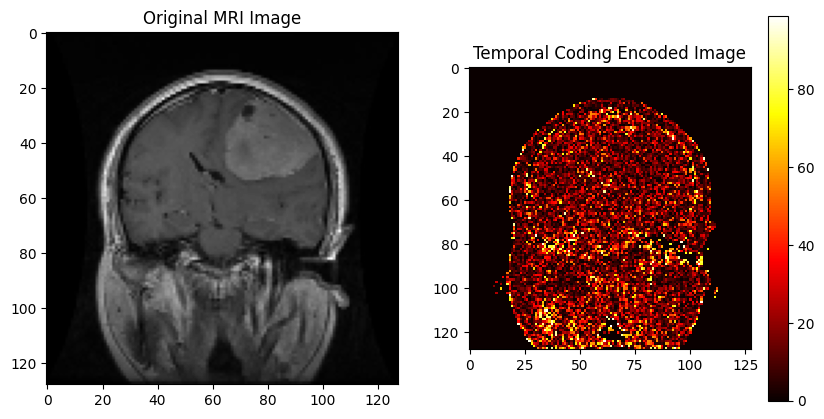

Displaying sample from class: no_tumor


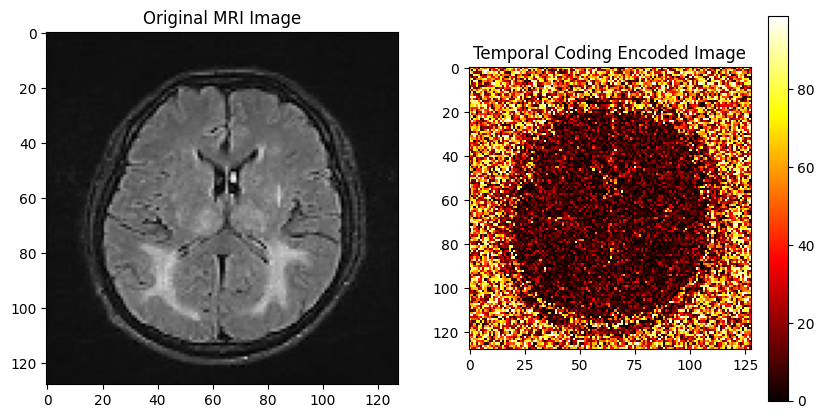

Displaying sample from class: pituitary_tumor


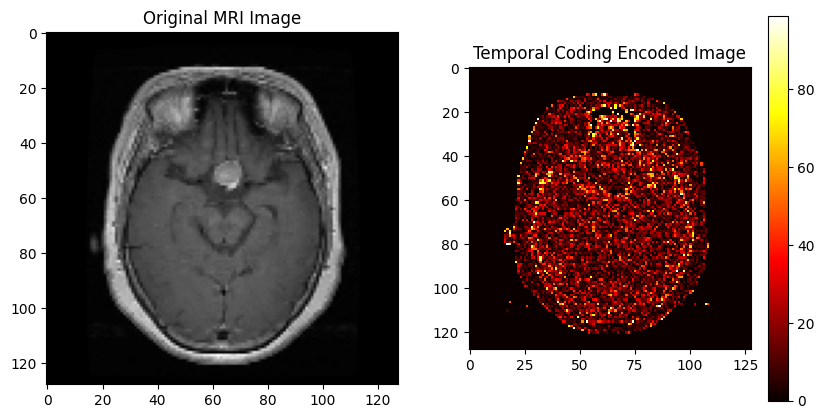

In [ ]:
random_class_sample(train_gen, encoding_type='temporal', num_samples=1)

In [ ]:
# https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9416238

In [ ]:
'''def encode_image(directory, encoding_type='rate', time_window=100, max_spikes=20):
    encoded_images = {}

    if encoding_type == 'rate':
        encode_function = encode_rate_coding
    elif encoding_type == 'temporal':
        encode_function = encode_temporal_coding
    else:
        raise ValueError(f"Unsupported encoding type: {encoding_type}")

    # Initialize an empty list to hold the spike trains for all images
    all_spike_trains = []

    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)

        if os.path.isdir(class_dir):
            encoded_images[class_name] = []

            # Iterate over all images in the class directory
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)

                # Encode the image using the selected encoding function
                spike_train = encode_function(image_path, time_window, max_spikes)

                # Append the spike train to the list for this class
                encoded_images[class_name].append(spike_train)

                # Append the spike train to the overall list
                all_spike_trains.append(spike_train)

    # Convert all_spike_trains to a numpy array (if needed)
    all_spike_trains_array = np.array(all_spike_trains)  # Shape: [num_images, height, width, time_steps]

    return encoded_images, all_spike_trains_array'''

'def encode_image(directory, encoding_type=\'rate\', time_window=100, max_spikes=20):\n    encoded_images = {}\n    \n    if encoding_type == \'rate\':\n        encode_function = encode_rate_coding\n    elif encoding_type == \'temporal\':\n        encode_function = encode_temporal_coding\n    else:\n        raise ValueError(f"Unsupported encoding type: {encoding_type}")\n    \n    # Initialize an empty list to hold the spike trains for all images\n    all_spike_trains = []\n    \n    for class_name in os.listdir(directory):\n        class_dir = os.path.join(directory, class_name)\n        \n        if os.path.isdir(class_dir):\n            encoded_images[class_name] = []\n            \n            # Iterate over all images in the class directory\n            for image_name in os.listdir(class_dir):\n                image_path = os.path.join(class_dir, image_name)\n                \n                # Encode the image using the selected encoding function\n                spike_train = en

### Encode all the images

#### Rate encoding

In [ ]:
def process_directory_with_encoding(input_dir, output_dir, encoding_function, time_window=100, max_spikes=20):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate through class directories
    for class_dir in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_dir)

        if os.path.isdir(class_path):
            # Create a subdirectory for each class in the output directory
            class_output_dir = os.path.join(output_dir, class_dir)
            if not os.path.exists(class_output_dir):
                os.makedirs(class_output_dir)

            # Iterate through all image files in the class directory
            for img_filename in os.listdir(class_path):
                img_path = os.path.join(class_path, img_filename)

                if img_filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    print(f"Processing {img_filename} in class {class_dir}...")

                    # Apply the selected encoding function
                    encoded_spike_train = encoding_function(img_path, time_window=time_window, max_spikes=max_spikes)

                    # Determine output filename based on the encoding function
                    encoding_type = "rate" if encoding_function.__name__ == "encode_rate_coding" else "temporal"
                    output_filename = f"{os.path.splitext(img_filename)[0]}_{encoding_type}_encoded.npy"
                    output_path = os.path.join(class_output_dir, output_filename)

                    # Save the encoded spike train
                    np.save(output_path, encoded_spike_train)
                    print(f"Saved {encoding_type}-encoded spike train for {img_filename} to {output_path}")

Processing image(162).jpg in class no_tumor...
Saved rate-encoded spike train for image(162).jpg to /home/pes1ug22am100/Documents/Research and Experimentation/neuralNeurosis/RateEncoding/Training/no_tumor/image(162)_rate_encoded.npy
Processing image(123).jpg in class no_tumor...
Saved rate-encoded spike train for image(123).jpg to /home/pes1ug22am100/Documents/Research and Experimentation/neuralNeurosis/RateEncoding/Training/no_tumor/image(123)_rate_encoded.npy
Processing image(86).jpg in class no_tumor...
Saved rate-encoded spike train for image(86).jpg to /home/pes1ug22am100/Documents/Research and Experimentation/neuralNeurosis/RateEncoding/Training/no_tumor/image(86)_rate_encoded.npy
Processing image (59).jpg in class no_tumor...
Saved rate-encoded spike train for image (59).jpg to /home/pes1ug22am100/Documents/Research and Experimentation/neuralNeurosis/RateEncoding/Training/no_tumor/image (59)_rate_encoded.npy
Processing image(164).jpg in class no_tumor...
Saved rate-encoded spike